## 1. IMPORTING

In [2]:
import tensorflow as tf
from keras.applications import EfficientNetB3
from keras import layers, models
import numpy as np
import os 

## 2. LOAD DATASET

In [3]:
img_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/processed/train",
    image_size=img_size,
    batch_size=16,
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/processed/val",    
    image_size=img_size,
    batch_size=16,
    seed=42
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/processed/test",   
    image_size=img_size,
    batch_size=16
)

# Get class names BEFORE prefetching
class_names = train_ds.class_names
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# Now apply prefetching
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Found 507 files belonging to 9 classes.
Found 142 files belonging to 9 classes.
Found 82 files belonging to 9 classes.
Number of classes: 9
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


## 3. BUILDING MODEL

In [4]:
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,320 (42.65 MB)

 Trainable params: 395,785 (1.51 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

## 4. TRAIN

In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5562 - loss: 1.3788 - val_accuracy: 0.8310 - val_loss: 0.5579
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8323 - loss: 0.5394 - val_accuracy: 0.9366 - val_loss: 0.2837
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8718 - loss: 0.3628 - val_accuracy: 0.9155 - val_loss: 0.2236
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9290 - loss: 0.2598 - val_accuracy: 0.9366 - val_loss: 0.1953
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9349 - loss: 0.2026 - val_accuracy: 0.9296 - val_loss: 0.1811
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9270 - loss: 0.1980 - val_accuracy: 0.9296 - val_loss: 0.1901
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9349 - loss: 0.1851 - val_accuracy: 0.8944 - val_loss: 0.2473
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9507 - loss: 0.1533 - val_accuracy: 0.9085 - val_loss:

## 5. FINE-TUNE

In [6]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 346s 8s/step - accuracy: 0.4438 - loss: 1.5465 - val_accuracy: 0.9437 - val_loss: 0.1389
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 231s 7s/step - accuracy: 0.5483 - loss: 1.3047 - val_accuracy: 0.9577 - val_loss: 0.1788
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 230s 7s/step - accuracy: 0.6746 - loss: 1.0270 - val_accuracy: 0.9296 - val_loss: 0.2262
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 226s 7s/step - accuracy: 0.7258 - loss: 0.9036 - val_accuracy: 0.9225 - val_loss: 0.2643
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 229s 7s/step - accuracy: 0.7673 - loss: 0.8017 - val_accuracy: 0.9366 - val_loss: 0.2897
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 228s 7s/step - accuracy: 0.8126 - loss: 0.6520 - val_accuracy: 0.9225 - val_loss: 0.3034
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.8836 - loss: 0.5364 - val_accuracy: 0.9225 - val_loss: 0.3047
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 228s 7s/step - accuracy: 0.8955 - loss: 0.4732 - val_accuracy: 0.9296 - v

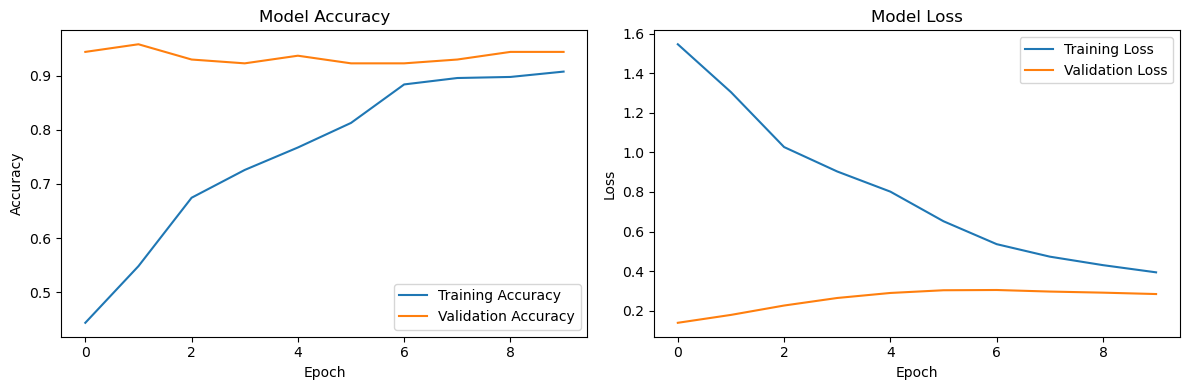

In [9]:
def unfreeze_model(model):
    for layer in model.layers[-10:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] #used sparse because classes are integers
    )
unfreeze_model(model)
epochs = 10 
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
plot_hist(hist)

## 6. EVALUATE ON TEST SET

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print("TEST ACCURACY:", test_acc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 972ms/step - accuracy: 0.9024 - loss: 0.3534
TEST ACCURACY: 0.9024389982223511


## 7. SAVE MODEL

In [11]:
model.save('Models/EfficientNetB3/efficientnetb3_model.keras')
print("Model saved as .keras file!")


Model saved as .keras file!


## 8. LOAD MODEL

In [12]:
from tensorflow import keras


loaded_model = keras.models.load_model('Models/EfficientNetB3/efficientnetb3_model.keras')

print("Model loaded successfully!")

Model loaded successfully!
